In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining all constants

KAPPA = 25.0
CHI = 0.65 * 2 * jnp.pi
N_MAX = 233
N_DEFAULT = 43 # assume all measurement are till steady-state, ie around 10/kappa = 400ns
mu_default = jnp.sqrt(N_MAX / N_DEFAULT)
amp_default = 1/mu_default
GAMMA_PHOTON = 1/2000
GAMMA_MEAS = 1/100
INIT_FID = 1 - 1e-3
SNR_SCALE = 2.3
STATE_STD = 1/jnp.sqrt(2)

In [4]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 25.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/100
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 1e-2
snr_scale_factor = 2.3
gamma_I = 1/100
num_t1 = 15.0
photon_gamma = 1/2000
init_fid = 1 - 1e-3
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 42.40791965946619


In [5]:
from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

b_size = 2

env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=b_size,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight
)

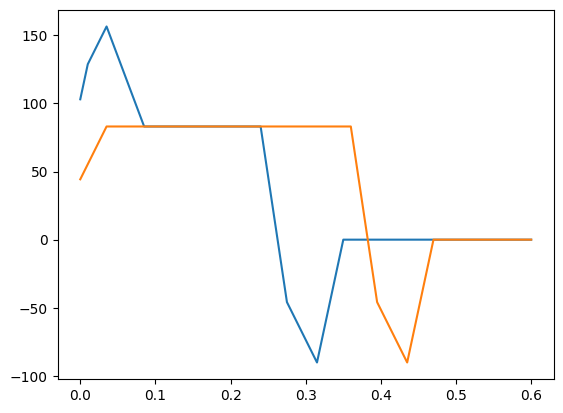

In [30]:
ts_action = env.ts_action

def get_action(tau_1, tau_2, tau_3, tau_4):
    action = jnp.heaviside(tau_1 -  ts_action, 0.)
    action += 1 / env.mu * (jnp.heaviside(tau_2 - ts_action, 0.) - jnp.heaviside(tau_1 - ts_action, 0.))
    action -= (jnp.heaviside(tau_3 - ts_action, 0.) - jnp.heaviside(tau_2 - ts_action, 0.))
    action += (jnp.heaviside(tau_4 - ts_action, 0.) - jnp.heaviside(tau_3 - ts_action, 0.))
    action *= env.a0 * env.mu
    return action

tau_1 = 0.047
tau_2 = 0.280
tau_3 = 0.313 # 153 is optimal
tau_4 = 0.313

action = get_action(tau_1, tau_2, tau_3, tau_4)

ts_kernel = jnp.linspace(-25, 25, 51)
gauss_std = 5.0
kernel = 1 / (jnp.sqrt(2 * jnp.pi) * gauss_std) * jnp.exp(-(ts_kernel/(jnp.sqrt(2) * gauss_std))**2)
kernel = jnp.ones(15) / 15
action = jnp.convolve(action, kernel, mode='same')

tau_1 = 0.
tau_2 = 0.4
tau_3 = 0.433 # 153 is optimal
tau_4 = 0.433

action_2 = get_action(tau_1, tau_2, tau_3, tau_4)
action_2 = jnp.convolve(action_2, kernel, mode='same')

# action = env.a0 * jnp.heaviside(0.398 - ts_action, 0.) * 0.2

# action_2 = env.a0 * (jnp.heaviside(0.370 - ts_action, 0.) - jnp.heaviside(0.029 - ts_action, 0.))
# action_2 += env.a0 * jnp.exp(-(ts_action - 0.029)**2/(jnp.sqrt(2)*0.0145)**2) * jnp.heaviside(0.029 - ts_action, 1.)
# action_2 += env.a0 * jnp.exp(-(ts_action - 0.370)**2/(jnp.sqrt(2)*0.0145)**2) * (jnp.heaviside(0.398 - ts_action, 0.) - jnp.heaviside(0.370 - ts_action, 0.))

plt.plot(ts_action, action)
plt.plot(ts_action, action_2)
plt.show()

photon 1 at 0.31333333333333335 is 0.9602009304474236
photon 1 at 0.32666666666666666 is 0.5320866275461806
Min Photon: 0.4344952617721084
Time of Min Photon: 321.6666666666667ns
photon 2 at 0.43333333333333335 is 0.12224817672167695
photon 2 at 0.4466666666666667 is 0.08759464626580352
Min Photon 2: 0.4433401407730217
Time of Min Photon 2: 441.6666666666667ns
Theory 1st Min Photons: 0.7937618713147362
Approx 1st Min Photons: 0.7914573112704112
0.2516666666666667
0.3666666666666667


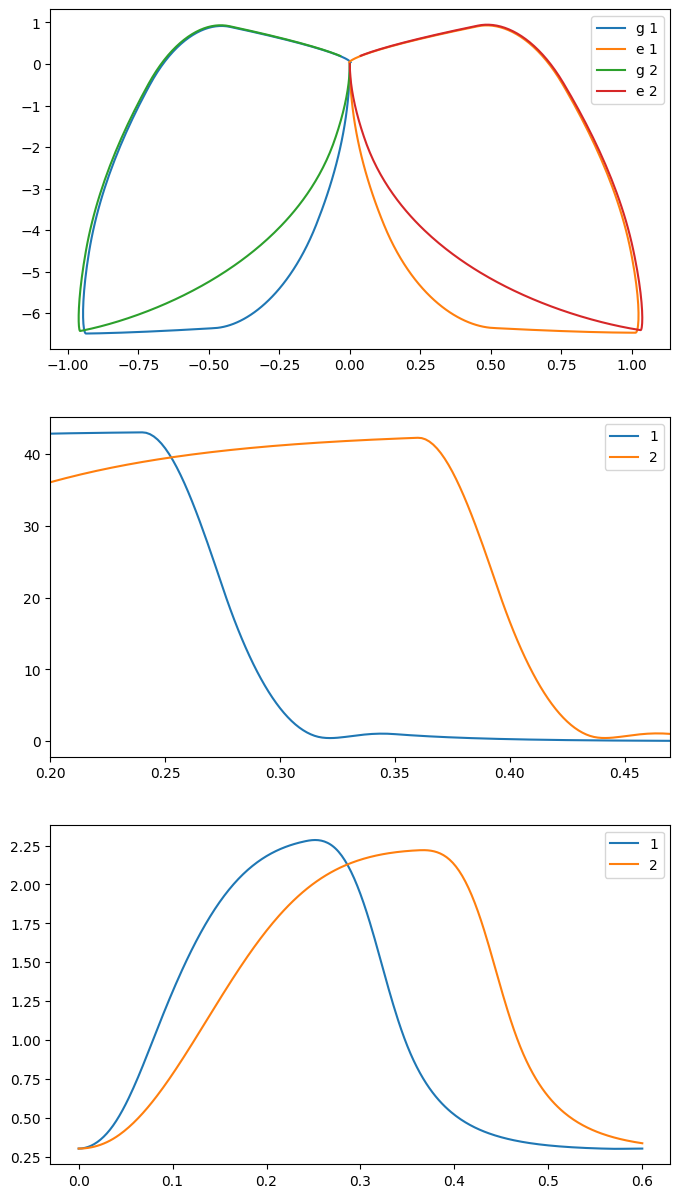

In [37]:
fig, ax = plt.subplots(3, figsize=(8.0, 15.0))

res_g_real, res_g_imag, res_e_real, res_e_imag = env.calc_results(action).T
res_g = res_g_real + 1.0j * res_g_imag
res_e = res_e_real + 1.0j * res_e_imag
photon = jnp.abs(res_g) ** 2

res_g_real, res_g_imag, res_e_real, res_e_imag = env.calc_results(action_2).T
res_g_2 = res_g_real + 1.0j * res_g_imag
res_e_2 = res_e_real + 1.0j * res_e_imag
photon_2 = jnp.abs(res_g_2) ** 2

time_1 = 0.313
time_11 = time_1 + 0.014
ind_1 = int(jnp.round(time_1/0.6 * 360))
print(f"photon 1 at {env.ts_sim[ind_1]} is {photon[ind_1]}")
ind_11 = int(jnp.round(time_11/0.6 * 360))
print(f"photon 1 at {env.ts_sim[ind_11]} is {photon[ind_11]}")
min_photon = jnp.min(photon[45:210])
print(f"Min Photon: {min_photon}")
print(f"Time of Min Photon: {env.ts_sim[45 + jnp.argmin(photon[45:210])]*1000}ns")

time_2 = 0.433
time_22 = time_2 + 0.014
ind_2 = int(jnp.round(time_2/0.6 * 360))
print(f"photon 2 at {env.ts_sim[ind_2]} is {photon[ind_2]}")
ind_22 = int(jnp.round(time_22/0.6 * 360))
print(f"photon 2 at {env.ts_sim[ind_22]} is {photon[ind_22]}")
min_photon_2 = jnp.min(photon_2[45:280])
print(f"Min Photon 2: {min_photon_2}")
print(f"Time of Min Photon 2: {env.ts_sim[45 + jnp.argmin(photon_2[45:280])]*1000}ns")

theory_min_photon = 2 * n0 * res_amp_scaling ** 2 * (1 - jnp.cos(chi / kappa * jnp.log(1 + 1/res_amp_scaling)))
approx_min_photon = n0 * res_amp_scaling ** 2 * (chi / kappa * jnp.log(3.33/2.33))**2
print(f"Theory 1st Min Photons: {theory_min_photon}")
print(f"Approx 1st Min Photons: {approx_min_photon}")

ax[0].plot(res_g.real, res_g.imag, label='g 1')
ax[0].plot(res_e.real, res_e.imag, label='e 1')
ax[0].plot(res_g_2.real, res_g_2.imag, label='g 2')
ax[0].plot(res_e_2.real, res_e_2.imag, label='e 2')
ax[0].legend()

ax[1].plot(env.ts_sim, photon, label='1')
ax[1].plot(env.ts_sim, photon_2, label='2')
ax[1].set_xlim(left=0.2, right=0.47)
ax[1].legend()

sep = jnp.abs(res_g - res_e)
sep_2 = jnp.abs(res_g_2 - res_e_2)

sep_fid = -jnp.log10(1 - 0.5 * (1. + erf(sep)) * jnp.exp(-gamma_I * env.ts_sim))
sep_fid_2 = -jnp.log10(1 - 0.5 * (1. + erf(sep_2)) * jnp.exp(-gamma_I * env.ts_sim))

print(env.ts_sim[jnp.argmax(sep_fid)])
print(env.ts_sim[jnp.argmax(sep_fid_2)])

ax[2].plot(env.ts_sim, sep_fid, label='1')
ax[2].plot(env.ts_sim, sep_fid_2, label='2')
ax[2].legend()

plt.show()